# Assignment 7: Model Predictive Control I (Solution)

University of California Berkeley

ME C231A, EE C220B, Experiential Advanced Control I

***

These notes were developed by Roya Firoozi and Francesco Borrelli at UC Berkeley. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

If you are enrolled in ME C231A/EE C220B you may take notes and make copies of course materials for your own use. You may also share those materials with another student who is registered and enrolled in this course, and with DSP.

You may not reproduce, distribute or display (post/upload) (Links to an external site.) lecture notes or recordings or course materials in any other way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Links to an external site.Berkeley Code of Student Conduct, including Sections 102.23 and 102.25.

***

In this homwowrk assignment, we are going to use $\texttt{Polytope}$ package. For more information please look at this link: https://tulip-control.github.io/polytope/
Note that this package is already installed on docker image. If you are using Google Colab please run the following cell which includes $\texttt{Polytope}$ package installation.  

In [ ]:
# This cell is commented out because Polytope package, Pyomo and solvers are already installed on Docker image.
# Please run this cell only if you are using Google Colab.

# # install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64
  !pip install polytope

The following helper functions compute Minkowski sum, precursor set and $\mathcal{O}_{\infty}$ set. Take a look at the code. You are going to use them in this howework.

In [ ]:
import polytope as pt
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget

# Helper Functions:

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X

    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))


# def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):

#     if not B.any():
#         if not pt.is_empty(Wset):
#             return pt.Polytope( pontryagin_diff(Xset, Wset).A @ A, Xset.b)
#         else:
#             return pt.Polytope(Xset.A @ A, Xset.b)

#     if not pt.is_empty(Wset):
#         tmp  = minkowski_sum( pontryagin_diff(Xset, Wset), pt.extreme(Uset) @ -B.T )
#         return pt.Polytope(tmp.A @ A, tmp.b)
#     else:
#         tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
#         return pt.Polytope(tmp.A @ A, tmp.b)
def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
        if not B.any():
            return pt.Polytope(Xset.A @ A, Xset.b)
        else:
            tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)



def Oinf(Xset, A, Wset=pt.Polytope()):

    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = pt.reduce(precursor(Omega, A, Wset=Wset).intersect(Omega))
        else:
            Omegap = pt.reduce(precursor(Omega, A).intersect(Omega))
    return Omegap


***

# 1. Formulation of CFTOC Problem with Pyomo

In this problem, you will write a function which formulates and solves a finite time optimal control problem with quadratic cost, linear dynamics, and linear constraints. You will be using this function in the next part of the homework as a part of your MPC controller. Consider the problem defined below:
\begin{equation}
\begin{aligned}
\min_{x_1 \dots x_N,u_0 \dots u_{N-1}} & \quad x_N^{\top}Px_N+\sum_{k=0}^{N-1}x_k^{\top}Qx_k+u_k^{\top}Ru_k \\
\text{s.t.} & \quad x_{k+1} = Ax_k + Bu_k \quad \forall k=0\dots N-1\\
& \quad x_{min} \leq x_k \leq x_{max}  \quad \forall k=0\dots N-1 \\
& \quad u_{min} \leq u_k \leq u_{max}  \quad \forall k=0\dots N-1 \\
& \quad x_0 = x(0) \\
& \quad x_N \in \mathcal{X}_f
\end{aligned}
\end{equation}

Write a function in the following form which formulates the problem using pyomo and solves the problem using the solver $\texttt{ipopt}$. Test your code on several 1 and 2-state examples.


- $\texttt{feas}$ is a scalar logical indicating the feasibility of the CFTOC problem
- $\texttt{xOpt}$ is a $n_x \times (N+1)$ matrix of the optimal state trajectory, where $n_x$ is the state dimension
- $\texttt{uOpt}$ is a $n_u \times N$ matrix of the optimal input sequence, where $n_u$ is the input dimension
- $\texttt{JOpt}$ is a scalar of the optimal cost from the specified initial condition
- $\texttt{A, B}$ are the state and input matricies of the linear dynamics
- $\texttt{P}$ is the terminal cost matrix
- $\texttt{Q, R}$ are the stage cost matricies
- $\texttt{N}$ is the MPC horizon
- $\texttt{x0}$ is the initial condition
- $\texttt{xL, xU, uL, uU}$ are the box state and input constraints
- $\texttt{bf, Af}$ are used to represent the terminal set. If the terminal set ${\cal X}_f$ is a single point, ${\cal X}_f = \{ \bar{x}_N \}$, the input argument $\texttt{bf}$ is used to specify this single point $\bar{x}_N$, and the input argument $\texttt{Af = []}$ is used to designate this special case of a single-point terminal set. If the terminal set is described by a set of linear inequalities, it can be expressed using the inequality $A_f x_N \leq b_f$.


In [ ]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
import polytope as pt
import matplotlib.pyplot as plt

A = np.array([[1.2, 1],
               [0, 1]])
B = np.array([[0],
              [1]])
Q = np.eye(2)
R = np.array([1]).reshape(1,1)
P = Q
N = 15
xL = -15
xU = 15
uL = -1
uU = 1
x0 = np.array([2, -1])

Af = np.array([[1, 0],
               [0, 1],
               [-1, 0],
               [0, -1]])

bf = np.zeros((4, ))

def solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf=np.nan, Af=np.nan):

    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(A, 0)
    model.nu = np.size(B, 1)
    model.nf = np.size(Af, 0)

    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )
    model.nfIDX = pyo.Set( initialize= range(model.nf), ordered=True )

    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    model.Af = Af
    model.bf = bf

    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX, bounds=(xL,xU))
    model.u = pyo.Var(model.uIDX, model.tIDX, bounds=(uL,uU))

    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += model.x[i, t] * model.Q[i, j] * model.x[j, t]
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
        for i in model.xIDX:
            for j in model.xIDX:
                costTerminal += model.x[i, model.N] * model.P[i, j] * model.x[j, model.N]
        return costX + costU + costTerminal

    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

    # Constraints:
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
    model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])

    def final_const_rule(model, i):
        return sum(model.Af[i, j] * model.x[j, model.N] for j in model.xIDX) <= model.bf[i]

    model.final_const = pyo.Constraint(model.nfIDX, rule=final_const_rule)

    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)

    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False

    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T

    JOpt = model.cost()

    return [model, feas, xOpt, uOpt, JOpt]

[model, feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf, Af)

JOpt= 9.178413774595368
xOpt= [[ 2.       1.4      0.72912  0.31353  0.11136  0.02947  0.00256 -0.00343
  -0.00317 -0.00185 -0.00087 -0.00034 -0.00011 -0.00002 -0.      -0.     ]
 [-1.      -0.95088 -0.5614  -0.26488 -0.10416 -0.03281 -0.00651  0.00095
   0.00195  0.00135  0.0007   0.0003   0.00011  0.00003  0.       0.     ]]


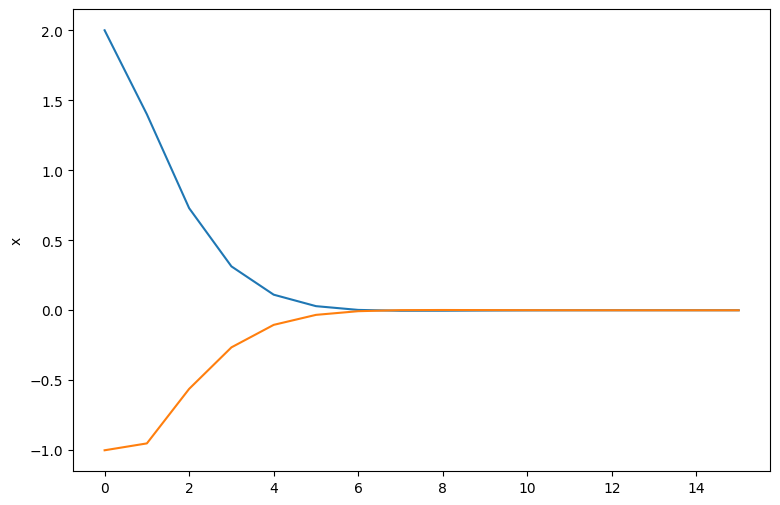

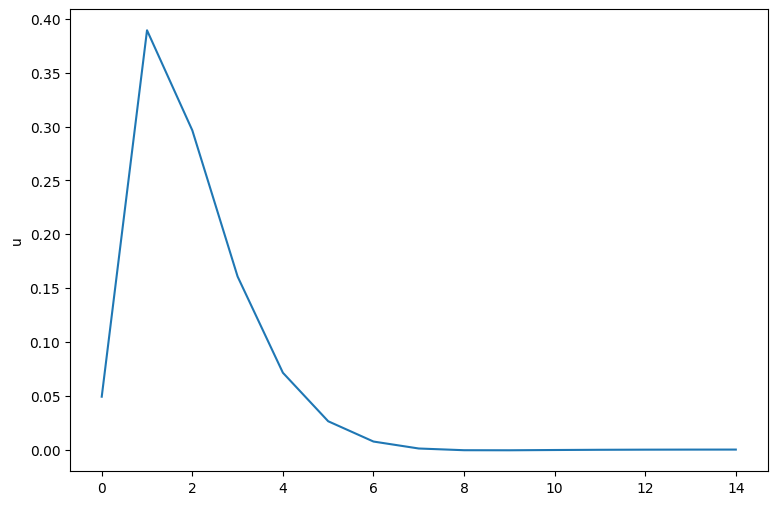

In [ ]:
print('JOpt=', JOpt)
print('xOpt=', xOpt)
fig = plt.figure(figsize=(9, 6))
plt.plot(xOpt.T)
plt.ylabel('x')
fig = plt.figure(figsize=(9, 6))
plt.plot(uOpt.T)
plt.ylabel('u')
plt.show()

***

# 2. Persistently Feasible and Asymptotically Stable Linear MPC design


Consider the following system
\begin{equation}\label{eq:model-int1}
x(k+1)=\begin{bmatrix} 1.2 &  1\\ 0 & 1 \end{bmatrix}x(k)+
     \begin{bmatrix} 0\\ 1 \end{bmatrix}u(k) \quad \quad (1)   
\end{equation}

The state and input constraints are
\begin{equation}\begin{aligned}
\mathcal{U}: &-1\leq u(k)\leq 1 \quad \quad \quad \quad \quad \quad \quad \quad \quad (2a)\\
\mathcal{X}: &\begin{bmatrix} -15\\ -15 \end{bmatrix} \leq x(k) \leq \begin{bmatrix} 15\\ 15 \end{bmatrix} \quad \quad \quad \quad \quad \quad (2b)
\end{aligned}
\label{eq:con1}\end{equation}

In this problem, we will design several MPC controllers of the form:

\begin{equation*}
   \begin{array}{lll}
       J_0^*(x_0)=  &\displaystyle{\min_{{U_0}}}& \displaystyle{ \color{red}{x_N'Px_N} + \sum_{k=0}^{{N}-1}
  x_k'Qx_k+u_k'Ru_k} \\
       &\text{subject to}   \\
       &&x_{k+1}=Ax_{k}+Bu_{k},\ k=0,\ldots,N-1\\
                       &&x_{k}\in\mathcal{X},~u_{k}\in\mathcal{U},~k=0,\ldots,N-1\\
                       && \color{red}{{x_{N}\in {\mathcal{X}_f} }} \\
                       && x_{0}=x(t)
    \end{array}
\end{equation*}
In this problem, we will fix  the dynamics ($A$, $B$), the constraint sets $\mathcal{X}$ and $\mathcal{U}$, $Q=I_2$, $R=1$, and $N=3$ and only examine how the choice of $P$ and $\mathcal{X}_f$ affect the set of feasible initial states $\mathcal{X}_0$.
$\textit{Note}$: Much of this exercise refers to the MPC and Reachability slides. Make sure you understand those slides before proceeding. Make sure you downloaded the latest sets of slides.



# Part a) Approach 1

Choose $\mathcal{X}_f=\{0\}$ (note that $x_N'Px_N=0$ for any $P$ since $x_N=0$). Write a function in the following format that formulates and solves the MPC problem over a simulation horizon $M$ from initial conditions $x_0$.

$\texttt{feas}$ is a $1 \times M$ vector of logicals that indicate the feasibility of the problem at each simulation step (e.g. if the problem is feasible for 3 steps, then $\texttt{feas}=[\texttt{true true true false} ... \texttt{false}])$ . If the problem becomes infeasible at any time, you should return empty arrays for $\texttt{xOpt}$, $\texttt{uOpt}$, and $\texttt{predErr}$.
$\texttt{xOpt}$ is an array of the optimal closed-loop trajectory of size $2 \times (M+1)$
$\texttt{uOpt}$ is an array of the optimal input sequence of size $1 \times M$
$\texttt{predErr}$ is a $1 \times (M-N+1)$ array of the $l_2$-norm of the difference between the open-loop predictions and the closed-loop trajectory for each state from simulation timestep 0 to $M-N$. To clarify further, the difference between the open-loop predictions and the closed-loop trajectory is a vector at each time, you need to take the $l_2$-norm of this vector to compute an element of the $\texttt{predErr}$ array.


You should call the function $\texttt{solve_cftoc}$, that you wrote in Problem 1, in the simulation time loop.

1.  Let $x(0) = [2,-1]^T$. Plot on the same figure the closed-loop state trajectory (plot $x(2)$ vs $x(1)$ as a solid line) as well as the open-loop trajectories (dashed lines) predicted by the MPC with a simulation horizon of $M=25$.

2. For the same $x(0) = [2,-1]^T$, analyze the mismatch between predicted vs closed-loop trajectories using the $\texttt{predErr}$ output as you increase $N$ in the MPC design. Show with plots how this prediction error changes with $N$.

3. Plot the set of feasible initial states $\mathcal{X}_0$. Note: You have two options by using brute-force gridding or by using polyhedral projections.

4. Is $\mathcal{X}_0$ an invariant set for the dynamic system (1) subject to the constraints (2) under the MPC law you designed? Justify your answer. (Hint: look at the Reachability slides for the definition of an invariant set.)

5. Is the MPC you just designed persistently feasible for all initial states in $\mathcal{X}_0$?  

6. Is the origin asymptotically stable for the closed loop system?

7.  What is its region of  attraction? (Hint: look at the MPC slides)

(2, 4)
[[ 0.       0.       0.       0.16158]
 [ 0.       0.       0.16158 -0.1661 ]]
error= [[0.39331]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]]


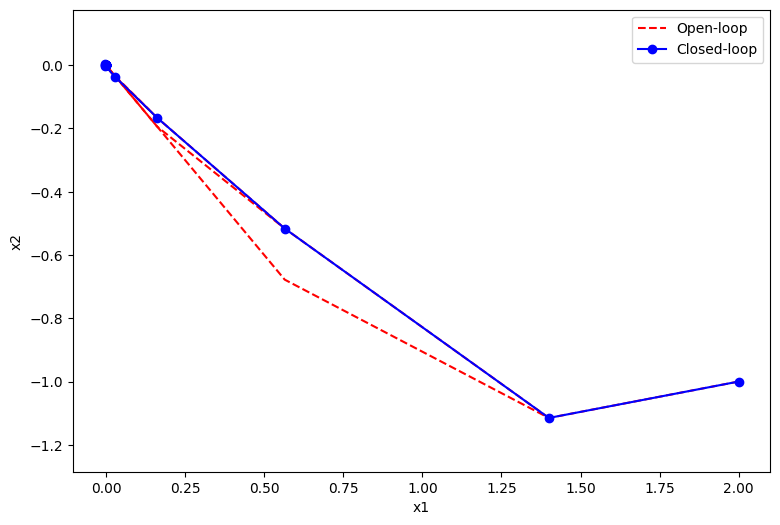

In [ ]:
import numpy as np
import polytope as pt

nx = np.size(A, 0)
nu = np.size(B, 1)

M = 25
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )
N = 3

xPred = np.zeros((nx, N+1, M))
predErr = np.zeros((1, M-N+1))

feas = np.zeros((M, ), dtype=bool)
xN = np.zeros((nx,1))

fig = plt.figure(figsize=(9, 6))
for time in range(M):
    [model, feas[time], x, u, J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:, time], xL, xU, uL, uU, bf, Af)

    if not feas[time]:
        xOpt = []
        uOpt = []
        predErr = []
        break
    # Save open loop predictions
    xPred[:, :, time] = x

    # Save closed loop trajectory
    # Note that the second column of x represents the optimal closed loop state
    xOpt[:, time+1] = x[:, 1]
    uOpt[:, time] = u[:, 0].reshape(nu, )

    # Plot Open Loop
    line1 = plt.plot(x[0,:], x[1,:], 'r--')

# Plot Closed Loop
line2 = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
# Find the prediction error
for time in range(len(predErr)):
    err = xOpt[:, time:time+N+1] - xPred[:,:, time]
    sum_ = 0
    for k in range(err.shape[1]):
      sum_ += np.linalg.norm(err[:,k])
    predErr[:, time] = sum_
print(err.shape)
print(err)



print('error=', predErr.T)
# print(err.shape)
# np.linalg.norm(err[0,:])
# print(err)
# print(predErr.T.shape)
# print(predErr)

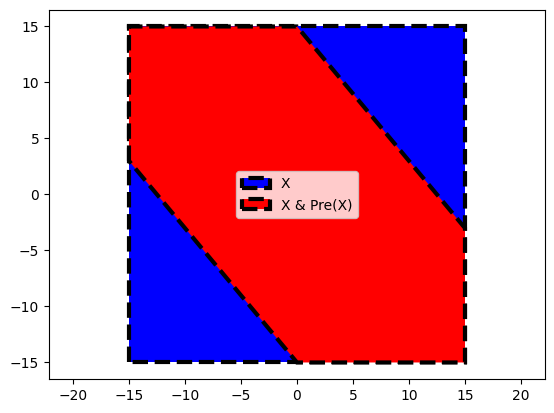

In [ ]:
A = np.array([[1.2, 1],
               [0, 1]])
B = np.array([[0],
              [1]])
xU = 15
uU = 1

# constraint sets represented as polyhedra
X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[xU],
                          [xU],
                          [xU],
                          [xU]]))

U = pt.Polytope(np.array([1, -1]).reshape(2,1),
                np.array([uU, uU]).reshape(2,1))

prep = precursor(X, A)
fig, ax = plt.subplots()
X.plot(ax, color='b')
prep.intersect(X).plot(ax, color='r')
ax.legend(['X', 'X & Pre(X)'])
ax.autoscale_view()
ax.axis('equal')
plt.show()

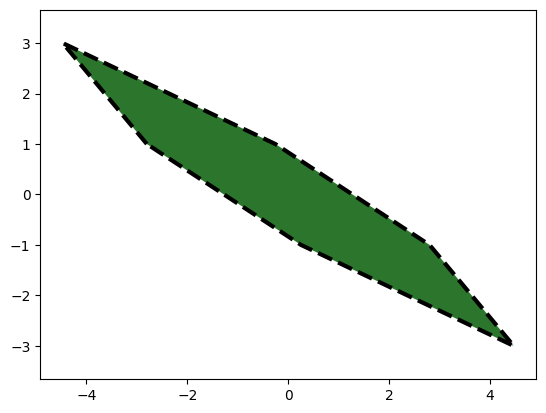

In [ ]:
# target set

C = {}
# Since the Polytope package cannot handle non full-dimensional
# polytopes, we need to define an epsilon box around zero in
# order to run the code:
eps = 0.001
S = pt.box2poly([[-eps, eps], [-eps, eps]])

fig, ax = plt.subplots()
PreS = precursor(S, A, U, B)
for k in range(N):
    C[k]= PreS.intersect(X)
    PreS = precursor(C[k], A, U, B)

X0_1 = C[N-1]
C[N-1].plot(ax)
ax.autoscale_view()
ax.axis('equal')
plt.show()

***

# Part b) Approach 2

To design our MPC, now use a stabilizing controller $u = Kx$ where $K$ is:
\begin{align*}
K &= -\begin{bmatrix}  1.595  &  2.35 \end{bmatrix}
\end{align*}
which  produces a stable closed loop system with poles at 0.1 and -0.25. Let $\color{red}{{X}_f}$ be the maximal invariant set $O_\infty$ for a closed loop system $x(k+1) = (A+BK)x(k)$ subject to
constraints (3).
Find a new terminal cost such that it is a Lyapunov Function for $x \in \color{red}{{X}_f} = O_\infty$ (note: you should be able to design a quadratic terminal cost with weight $P$ by simply using $\texttt{dlyap}$.) Write the code to formulate and solve the MPC problem. (Note: Your MPC code will be largely similar to your previous one, with the exception that you are now using different terminal constraints)

$\texttt{feas}$ is a $1 \times M$ vector of logicals that indicate the feasibility of the problem at each simulation step (e.g. if the problem is feasible for 3 steps, then $\texttt{feas}=[\texttt{true true true false} ... \texttt{false}]$ . If the problem becomes infeasible at any time, you should return empty arrays for $\texttt{xOpt}$, $\texttt{uOpt}$, and $\texttt{predErr}$.
$\texttt{xOpt}$ is an array of the optimal closed-loop trajectory of size $2 \times (M+1)$
$\texttt{uOpt}$ is an array of the optimal input sequence of size $1 \times M$
$\texttt{predErr}$ is a $1 \times (M-N+1)$ array of the $l_2$-norm of the difference between the open-loop predictions and the closed-loop trajectory for each state from simulation timestep 0 to $M-N$. To clarify further, the difference between the open-loop predictions and the closed-loop trajectory is a vector at each time, you need to take the $l_2$-norm of this vector to compute an element of the $\texttt{predErr}$ array.

You should call the function $\texttt{solve_cftoc}$, that you wrote in Problem 1, in the simulation time loop.

1.  Let $x(0) = [2,-1]^T$. Plot on the same figure the closed-loop state trajectory (plot $x(2)$ vs $x(1)$ as a solid line) as well as the open-loop trajectories (dashed lines) predicted by the MPC with a simulation horizon of $M=25$.

2. For the same $x(0) = [2,-1]^T$, analyze the mismatch between predicted vs closed-loop trajectories using the $\texttt{predErr}$ output as you increase $N$ in the MPC design. Show with plots how this prediction error changes with $N$.

3. Plot the set of feasible initial states $\mathcal{X}_0$. Note: You have two options by using brute-force gridding or by using polyhedral projections.

4. Is $\mathcal{X}_0$ an invariant set for the dynamic system (1) subject to the constraints (2) under the MPC law you designed? Justify your answer. (Hint: look at the Reachability slides for the definition of an invariant set and the MPC slides.)

5. Is the MPC you just designed persistently feasible for all initial states in $\mathcal{X}_0$?

6. Is the origin asymptotically stable for the closed loop system?

7.  What is its region of attraction?

error= [[0.09606]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]
 [0.     ]]


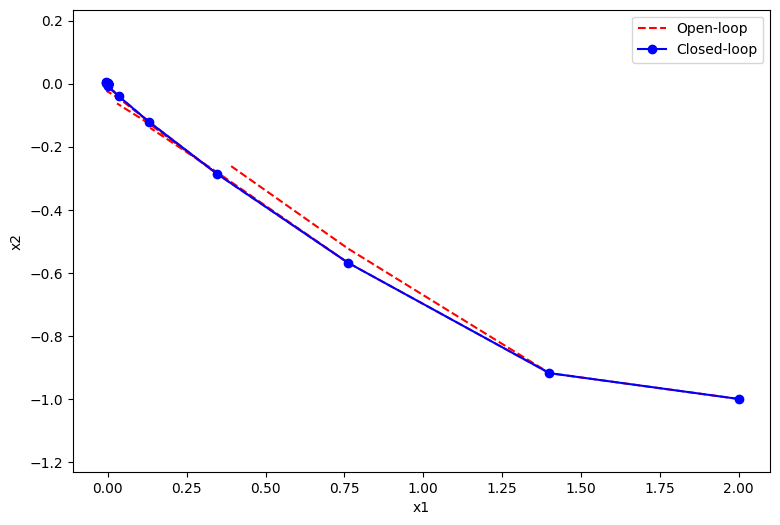

In [ ]:
import scipy.linalg
import numpy as np
import polytope as pt

K = -np.array([1.595, 2.35]).reshape(1,2)
A_cl = A + B@K
P_2 = scipy.linalg.solve_discrete_lyapunov(A_cl.T, Q+K.T@R@K) #You could also use Q
# print(P_2)
S = X.intersect(pt.Polytope(U.A@K, U.b))
O_inf = Oinf(S, A_cl)
Af = O_inf.A
bf = O_inf.b

nx = np.size(A, 0)
nu = np.size(B, 1)
x0 = np.array([2, -1])
M = 25
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )

xPred = np.zeros((nx, N+1, M))
predErr = np.zeros((1, M-N+1))

feas = np.zeros((M, ), dtype=bool)
xN = np.zeros((nx,1))

fig = plt.figure(figsize=(9, 6))
for time in range(M):
    [model, feas[time], x, u, J] = solve_cftoc(A, B, P, Q, R, N, xOpt[:, time], xL, xU, uL, uU, bf, Af)

    if not feas[time]:
        xOpt = []
        uOpt = []
        predErr = []
        break
    # Save open loop predictions
    xPred[:, :, time] = x

    # Save closed loop trajectory
    # Note that the second column of x represents the optimal closed loop state
    xOpt[:, time+1] = x[:, 1]
    uOpt[:, time] = u[:, 0].reshape(nu, )

    # Plot Open Loop
    line1 = plt.plot(x[0,:], x[1,:], 'r--')

# Plot Closed Loop
line2 = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
# fig2 = plt.figure(figsize=(9,6))
# ax1 = plt.axes()
# pt.Polytope(Af,bf).plot(ax1)
# plt.ylim((-1,1))
# Find the prediction error
for time in range(len(predErr)):
    err = xOpt[:, time:time+N+1] - xPred[:,:, time]
    sum_ = 0
    for k in range(err.shape[1]):
      sum_ += np.linalg.norm(err[:,k])
    predErr[:, time] = sum_

print('error=', predErr.T)


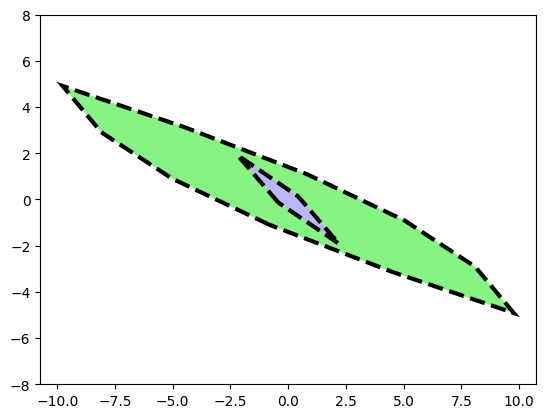

In [ ]:
# target set
# %matplotlib widget

C = {}

fig, ax = plt.subplots()
PreS = precursor(O_inf, A, U, B)
for k in range(N):
    C[k]= PreS.intersect(X)
    PreS = precursor(C[k], A, U, B)

X0_2 = C[N-1]
C[N-1].plot(ax)
pt.Polytope(Af,bf).plot(ax)
ax.autoscale_view()
ax.axis('equal')
plt.show()

***

# Part c) Approach 3
Now set $\mathcal{X}_f$ to be the maximal invariant set $O_\infty$ for the closed loop system $x(k+1) = (A+BF_\infty)x(k)$ subject to
the given constraints. Here $F_\infty$ is the infinite time LQR controller for the system $x(k+1) = Ax(k)+Bu(k)$ with weights $Q$ and $R$ defined previously, such that $u(k)=F_{\infty}x(k)$. Choose the terminal cost $P$ to be the infinite time cost associated with the controller $F_\infty$. Write your code in the following format that formulates and solves the MPC problem. (Note: your code will be largely similar to your previous one, with the exception that you are now using different terminal constraints)

1. Plot $O_\infty$ in this approach  with the one in Approach 2 and discuss the differences.

2. Let $x(0) = [2,-1]^T$ and plot the closed-loop state trajectory as well as the open-loop trajectories predicted by the MPC with this new terminal cost and terminal constraint for 25 simulation steps ($N$ is still equal to 3). How does this compare to the other solutions?

3. Plot the set of  feasible initial states $\mathcal{X}_0$. Note: You have two options by using brute-force gridding or by using polyhedral projections.

4. Is $\mathcal{X}_0$ an invariant set for the dynamic system (1) subject to the constraints (2) under the MPC law you designed? Justify your answer.


5. Is the MPC you just designed persistently feasible for all initial states in $\mathcal{X}_0$?


6. Is the origin asymptotically stable for the closed loop system?


7. What is its region of  attraction?

error= [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


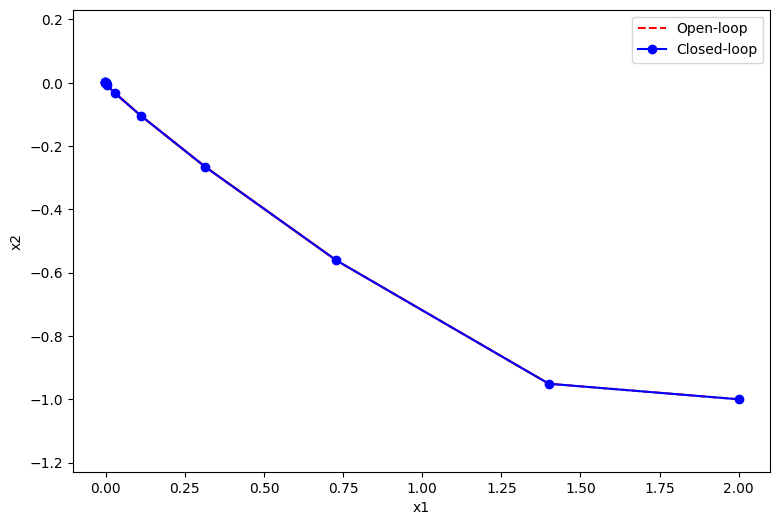

In [ ]:
import scipy.linalg

def dlqr(A, B, Q, R):
    # solve Discrete Algebraic Riccatti equation
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # compute the LQR gain
    K = -scipy.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)

    # stability check
    eigVals, eigVecs = scipy.linalg.eig(A + B @ K)
    return K, P, eigVals

F_inf, P_inf, eigvals = dlqr(A, B, Q, R)
A_cl = A + B@F_inf
S = X.intersect(pt.Polytope(U.A@F_inf, U.b))
O_inf = Oinf(S, A_cl)
Af = O_inf.A
bf = O_inf.b

M = 25
x0 = np.array([2,-1])
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )

xPred = np.zeros((nx, N+1, M))
predErr = np.zeros((1, M-N+1))

feas = np.zeros((M, ), dtype=bool)
xN = np.zeros((nx,1))

fig = plt.figure(figsize=(9, 6))
for time in range(M):
    [model, feas[time], x, u, J] = solve_cftoc(A, B, P_inf, Q, R, N, xOpt[:, time], xL, xU, uL, uU, bf, Af)

    if not feas[time]:
        xOpt = []
        uOpt = []
        predErr = []
        break
    # Save open loop predictions
    xPred[:, :, time] = x

    # Save closed loop trajectory
    # Note that the second column of x represents the optimal closed loop state
    xOpt[:, time+1] = x[:, 1]
    uOpt[:, time] = u[:, 0].reshape(nu, )

    # Plot Open Loop
    line1 = plt.plot(x[0,:], x[1,:], 'r--')

# Plot Closed Loop
line2 = plt.plot(xOpt[0, :], xOpt[1, :], 'bo-')
plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')
# Find the prediction error
for time in range(len(predErr)):
    err = xOpt[:, time:time+N+1] - xPred[:,:, time]
    sum_ = 0
    for k in range(err.shape[1]):
      sum_ += np.linalg.norm(err[:,k])
    predErr[:, time] = sum_

print('error=', predErr.T)


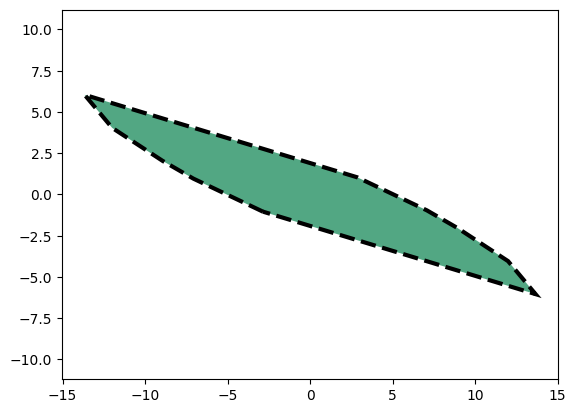

In [ ]:
# target set
# %matplotlib widget

C = {}
fig, ax = plt.subplots()
PreS = precursor(O_inf, A, U, B)
for j in range(N):
    C[j]= PreS.intersect(X)
    PreS = precursor(C[j], A, U, B)

X0_3 = C[N-1]
C[N-1].plot(ax)
ax.autoscale_view()
ax.axis('equal')
plt.show()

***

# Part d) Comparison
Compare $\mathcal{X}_0$ for the three MPC designs (Approach 1,2, and 3) for $N=3$. What do you notice?

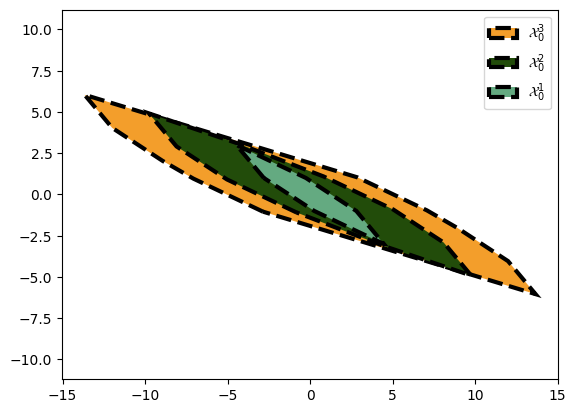

In [ ]:
fig, ax = plt.subplots()
X0_3.plot(ax)
X0_2.plot(ax)
X0_1.plot(ax)
ax.autoscale_view()
ax.axis('equal')
plt.legend(['$\mathcal{X}_0^3$','$\mathcal{X}_0^2$','$\mathcal{X}_0^1$'])
plt.show()